# MRI and Alzheimers 
## BIOF509 Spring 2019 Frinal Project

## Import Dataset

In [1]:
# This project is trying to find the best method to predict whether the patient will get
# Dementia/Alzheimers or not given the data
# Data should not be combined, each dataset should not be used individually only.

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# merge two datasets
# mri_cross = pd.read_csv('oasis_cross-sectional.csv', sep = ',')
mri_long = pd.read_csv('oasis_longitudinal.csv', sep = ',')
mri_long.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [2]:
# closer look to the score and labels
mri_long.groupby(['CDR', 'Group']).size().unstack()

Group,Converted,Demented,Nondemented
CDR,,,
0.0,18.0,NaN,188.0
0.5,19.0,102.0,2.0
1.0,NaN,41.0,NaN
2.0,NaN,3.0,NaN


In [3]:
mri_long.isnull().sum()

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

## Pre-Process

In [4]:
# the data contains more than one visits, we only keep single visit = 1
# no converted patients included
# MR Delay == 0
# df = mri_long.loc[mri_long['Visit'] == 1]
df = mri_long
df = df.drop(['Subject ID', 'MRI ID', 'Hand', 'MR Delay'], axis = 1)
display(df.head(), df.shape)

,Group,Visit,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,Nondemented,1,M,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,Nondemented,2,M,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,Demented,1,M,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,Demented,2,M,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,Demented,3,M,80,12,NaN,22.0,0.5,1698,0.701,1.034


(373, 11)

In [5]:
# missing values at the initial Visit
# SES (Socioeconomics Status)
df.isnull().sum()

Group     0
Visit     0
M/F       0
Age       0
EDUC      0
SES      19
MMSE      2
CDR       0
eTIV      0
nWBV      0
ASF       0
dtype: int64

In [6]:
from sklearn.preprocessing import LabelEncoder

df['CDR_code']= LabelEncoder().fit_transform(df['CDR'])
# df[['CDR_code', 'CDR']]

In [7]:
# MMSE Scores Mini-Mental State Examination - Ordinal
# Ref: https://www.heartandstroke.ca/-/media/pdf-files/canada/clinical-update/allen-huang-cognitive-screening-toolkit.ashx?la=en&hash=631B35521724C28268D0C2130D07A401E33CDBB0
# 25-30 (Questionably significant); 20-25 (Mild); 10-20 (Moderate); 0-10 (Severe)
def mmse_group(col):
    if col <= 10:
        return "Severe"
    elif 10 < col <= 20:
        return "Moderate"
    elif 20 < col <= 25:
        return "Mild"
    elif 25 < col <= 30:
        return "Questionably significant"
    else:
        return "missing"

def mmse_code(col):
    if col <= 10:
        return "3"
    elif 10 < col <= 20:
        return "2"
    elif 20 < col <= 25:
        return "1"
    elif 25 < col <= 30:
        return "0"
    else:
        return "-1"
df['MMSE Group'] = df['MMSE'].apply(mmse_group)
df['MMSE Group'].value_counts(sort = True)

df['MMSE_code'] = df['MMSE'].apply(mmse_code)
df.head()
# mmse_group = df[["MMSE Group"]]
# mmse_code = ode.fit_transform(mmse_group)
# df['MMSE_code'] = mmse_code
# df.groupby(['MMSE_code', 'MMSE Group']).count()

,Group,Visit,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,CDR_code,MMSE Group,MMSE_code
0,Nondemented,1,M,87,14,2.0,27.0,0.0,1987,0.696,0.883,0,Questionably significant,0
1,Nondemented,2,M,88,14,2.0,30.0,0.0,2004,0.681,0.876,0,Questionably significant,0
2,Demented,1,M,75,12,NaN,23.0,0.5,1678,0.736,1.046,1,Mild,1
3,Demented,2,M,76,12,NaN,28.0,0.5,1738,0.713,1.010,1,Questionably significant,0
4,Demented,3,M,80,12,NaN,22.0,0.5,1698,0.701,1.034,1,Mild,1


In [8]:
# M/F F = 0, M = 1
df['Gender_code'] = LabelEncoder().fit_transform(df['M/F'])

# Group Demented = 1, Nondemented = 2
df['Group_code'] = LabelEncoder().fit_transform(df['Group'])

df[['M/F', 'Gender_code', 'Group', 'Group_code']].head()

,M/F,Gender_code,Group,Group_code
0,M,1,Nondemented,2
1,M,1,Nondemented,2
2,M,1,Demented,1
3,M,1,Demented,1
4,M,1,Demented,1


In [9]:
display(df.info(), df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 16 columns):
Group          373 non-null object
Visit          373 non-null int64
M/F            373 non-null object
Age            373 non-null int64
EDUC           373 non-null int64
SES            354 non-null float64
MMSE           371 non-null float64
CDR            373 non-null float64
eTIV           373 non-null int64
nWBV           373 non-null float64
ASF            373 non-null float64
CDR_code       373 non-null int64
MMSE Group     373 non-null object
MMSE_code      373 non-null object
Gender_code    373 non-null int64
Group_code     373 non-null int64
dtypes: float64(5), int64(7), object(4)
memory usage: 46.7+ KB


None

Index(['Group', 'Visit', 'M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV',
       'nWBV', 'ASF', 'CDR_code', 'MMSE Group', 'MMSE_code', 'Gender_code',
       'Group_code'],
      dtype='object')

## Data Exploration

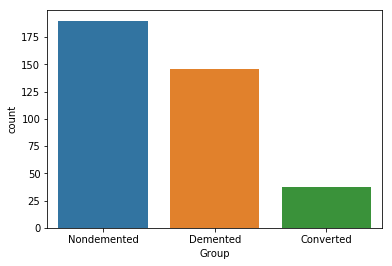

In [10]:
# Demented > ND at patients' initial visit
sns.countplot(x = 'Group', data = df)

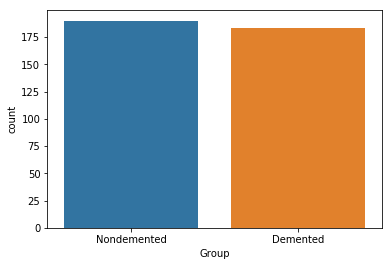

In [11]:
# converted --> Demented
df['Group'] = df['Group'].replace(['Converted'],['Demented'])
sns.countplot(x = 'Group', data = df)

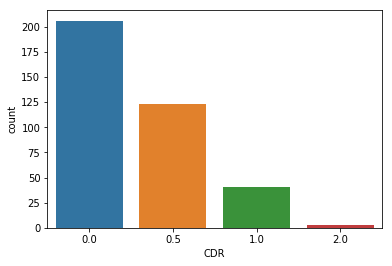

In [12]:
sns.countplot(x = 'CDR', data= df)

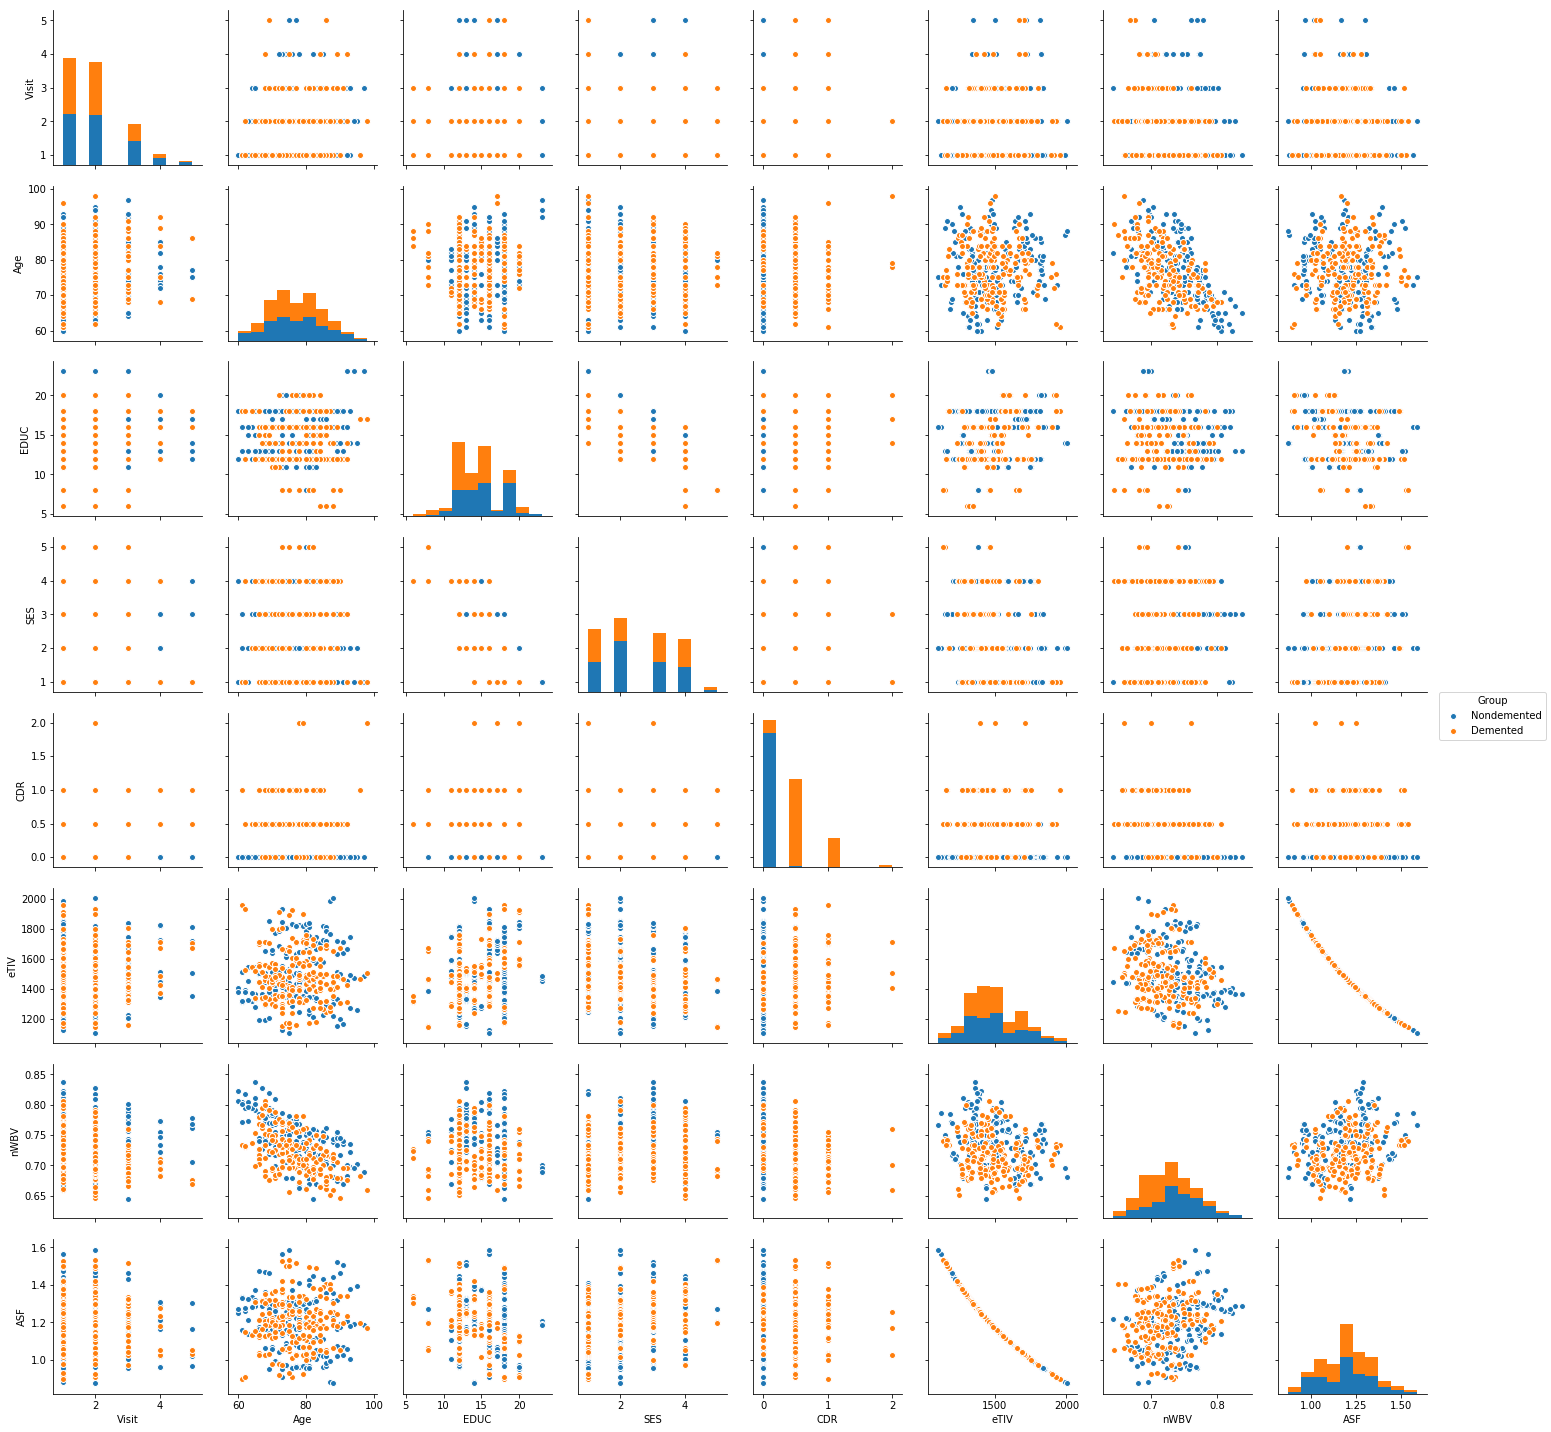

In [13]:
# multicolinearity exists
cols1 = ['Group', 'M/F', 'Visit', 'Age', 'EDUC', 'SES', 'MMSE Group', 'CDR', 'eTIV', 'nWBV','ASF']
df1 = df[cols1]
p1 = sns.pairplot(df1, hue = 'Group')

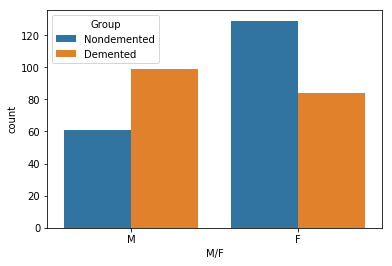

In [14]:
# lets see 'Group' relationships with other predictors one by one
# Gender: M/F
# Demented male > ND male ; ND female > Demented female
# female less likely to be Demented than male
sns.countplot(x = 'M/F', hue = 'Group', data = df)

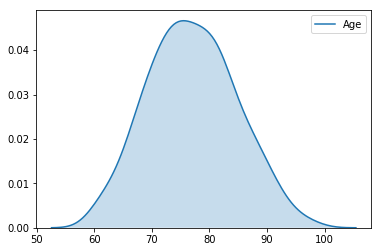

In [15]:
# Age vs Group
sns.kdeplot(df['Age'], shade = True)

### Remove NA & Impute

In [16]:
# columns included in the analysis
cols2 = ['Group_code', 'Gender_code', 'Visit', 'Age', 'EDUC', 'SES', 
         'MMSE_code', 'CDR_code', 'eTIV', 'nWBV', 'ASF']
df_cd = df[cols2]

# remove NA
df_rmna = df_cd.dropna()

# impute 
# df_ipna = df.

### Normalization

In [18]:
# recoded categorical varibles (Group_code)
# Group, M/F nominal
# CDR ordinal
x_cols = ['Gender_code', 'Visit', 'Age', 'EDUC', 'SES', 'MMSE_code', 'CDR_code', 'eTIV', 'nWBV', 'ASF']

X = df_rmna[x_cols]
y = df_rmna['Group_code']

## Modeling

In [44]:
# decision tree
# random forest
# SVM
# logistic regression
# KNN (handles nonlinearity)
# loss function (measures how good we predict each example, SSE commonly used)
# cost function (loss function for all training examples, MSE)
# minimize cost function by solving an optimize problem
# gradient descent: gradient shows the direction towards the minimum
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

cat_cols = ['Group_code', 'Gender_code', 'MMSE_code', 'CDR_code']
num_cols = ['Visit', 'Age', 'EDUC', 'SES', 'eTIV', 'nWBV', 'ASF']

# normalization
# training set
X_train_norm = StandardScaler().fit_transform(X_train[num_cols])
training_norm_col = pd.DataFrame(X_train_norm, index = X_train[num_cols].index, columns = X_train[num_cols].columns)
X_train.update(training_norm_col)

# test set
X_test_norm = StandardScaler().fit_transform(X_test[num_cols])
test_norm_col = pd.DataFrame(X_test_norm, index = X_test[num_cols].index, columns = X_test[num_cols].columns)
X_test.update(test_norm_col)

# whole set
X_norm = StandardScaler().fit_transform(X[num_cols])
norm_col = pd.DataFrame(X_norm, index = X[num_cols].index, columns = X[num_cols].columns)
X.update(norm_col)


X_train.shape, y_train.shape

C:\Users\ssun\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:5082: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)


((237, 10), (237,))

In [24]:
X_test.shape, y_test.shape

((117, 10), (117,))

In [55]:
# logistic regression
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

lr = LogisticRegression(solver = 'lbfgs', max_iter=1000)

lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)
mean_squared_error(y_test, y_predict)

0.3333333333333333

In [49]:
# CV
lr.fit(X, y)
y_predict = lr.predict(X)

cv = KFold(n_splits=5, shuffle=True, random_state=10)
abs(np.mean(cross_val_score(lr, X, y, cv=5, scoring="neg_mean_squared_error")))

0.26801587301587304

In [53]:
# lasso
llr = Lasso(alpha=0.5)
llr.fit(X, y)
preds = llr.predict(X)

# Create the CV iterator
cv_iterator = KFold(n_splits=5, shuffle=True, random_state=10)
abs(np.mean(cross_val_score(llr, X, y, cv=5, scoring="neg_mean_squared_error")))

0.4568692024158817

In [56]:
# Ridge regression
from sklearn.linear_model import Ridge

llr = Ridge(alpha=0.5)
llr.fit(X, y)
preds = llr.predict(X)

# Create the CV iterator
cv_iterator = KFold(n_splits=5, shuffle=True, random_state=10)
abs(np.mean(cross_val_score(llr, X, y, cv=5, scoring="neg_mean_squared_error")))

0.30417756879138835

In [41]:
# Decision Tree 
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(max_depth = 5)
dtr.fit(X_train, y_train)
y_predict = dtr.predict(X_test)
mean_squared_error(y_test, y_predict)


0.32774746944708794

In [42]:
# Random Forest (bagging)
from sklearn.ensemble import RandomForestRegressor

rf= RandomForestRegressor()
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)
mean_squared_error(y_test, y_predict)

0.2986324786324786

In [43]:
# Gradient Boosting (boosting)
# sequential improvement of models by training on their errors
# improves errors, one tree each step
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)
y_predict = gb.predict(X_test)
mean_squared_error(y_test, y_predict)

0.3366935079866339

In [59]:
# SVM
from sklearn.svm import SVC

clf = svm.SVC(gamma='auto')
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
mean_squared_error(y_test, y_predict)

NameError: name 'svm' is not defined

In [61]:
# KNN
from sklearn.neighbors import KNeighborsRegressor

y_predict = KNeighborsRegressor(n_neighbors=5).fit(X_train, y_train).predict(X_test)
mean_squared_error(y_test, y_predict)

0.34632478632478625